In [1]:
##########################################
#Step 0: Import libraries
##########################################

In [2]:
#generic data analysis 
import os
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

In [59]:
#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Reporting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [4]:
##########################################
#Step 1: Import data
##########################################

In [5]:
#Setting directory
directory = r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Data Analytics Essentials\UCDPA_JohnLenehan\UCDPA_JohnLenehan'
os.chdir(directory)

In [6]:
#importing car crash data from chicago data portal
#url to overview page - https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
collision_json = r'https://data.cityofchicago.org/resource/85ca-t3if.json?$limit=100000' #json url

#using read_json function to read in dataset
collision_raw = pd.read_json(collision_json) #reading collisions json

In [7]:
print(collision_raw.head())

                                     crash_record_id               crash_date  \
0  25d92973475a04a93e7fd206fbfce57e8a9a1e25cc85a7...  2023-05-16T23:12:00.000   
1  375ac7f6fcb4ef73d728edc52ed556f23fd465a351833f...  2023-05-16T23:06:00.000   
2  246fea010af2010860046c6ef36efb75a8c60244088939...  2023-05-16T23:05:00.000   
3  18c220f7eeceb2cf6f9512c9b83382da28d8565fbbaaec...  2023-05-16T22:20:00.000   
4  cfecdce601503162eb09337bd6051ea358dca7294d440b...  2023-05-16T21:45:00.000   

   posted_speed_limit traffic_control_device      device_condition  \
0                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
1                  30            NO CONTROLS           NO CONTROLS   
2                  30            NO CONTROLS           NO CONTROLS   
3                  25            NO CONTROLS           NO CONTROLS   
4                  30                UNKNOWN  FUNCTIONING PROPERLY   

  weather_condition      lighting_condition      first_crash_type  \
0             CLEAR  DA

In [8]:
#importing beat data to join to main dataset
#source - Chicago Data Portal
#beat data url - https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Beats-current-/aerh-rz74
beat_data=pd.read_csv('PoliceBeatDec2012.csv')

print(beat_data.info())
print(beat_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277 entries, 0 to 276
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   the_geom  277 non-null    object
 1   DISTRICT  277 non-null    int64 
 2   SECTOR    277 non-null    int64 
 3   BEAT      277 non-null    int64 
 4   BEAT_NUM  277 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.9+ KB
None
         DISTRICT      SECTOR        BEAT     BEAT_NUM
count  277.000000  277.000000  277.000000   277.000000
mean    12.122744    2.028881    2.028881  1235.241877
std      7.232131    0.924249    0.924249   722.945828
min      1.000000    0.000000    0.000000   111.000000
25%      6.000000    1.000000    1.000000   633.000000
50%     11.000000    2.000000    2.000000  1131.000000
75%     18.000000    3.000000    3.000000  1813.000000
max     31.000000    5.000000    5.000000  3100.000000


In [9]:
##########################################
#Step 2: Merge Data
##########################################

In [10]:
#joining collision data to beat data - inner join
collisions = collision_raw.merge(beat_data, how='inner',
                                 left_on='beat_of_occurrence',
                                 right_on='BEAT_NUM'
                                 )

print(collisions.head())

                                     crash_record_id               crash_date  \
0  25d92973475a04a93e7fd206fbfce57e8a9a1e25cc85a7...  2023-05-16T23:12:00.000   
1  9cc82b5ba91f3da11c5bc561a8cfc090b30424ede46fec...  2023-05-16T15:00:00.000   
2  2a5a2c1d2620e5f81362d99d4956a80884413241471bb7...  2023-05-15T20:40:00.000   
3  caf58dafbea706f6d18c6016ca7aee6443db31f285b662...  2023-05-14T17:07:00.000   
4  49ddea33f1e483cffcbb1c2595527f7a3ec1484d14a9d8...  2023-05-14T16:00:00.000   

   posted_speed_limit traffic_control_device      device_condition  \
0                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
1                  30            NO CONTROLS           NO CONTROLS   
2                  30            NO CONTROLS           NO CONTROLS   
3                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
4                  30            NO CONTROLS           NO CONTROLS   

  weather_condition      lighting_condition          first_crash_type  \
0             CLEAR

In [71]:
#alternatively - can get district from first 2 digits of beat of occurrence
collisions['district'] = collisions['beat_of_occurrence'].str.replace(r'^\d{2}', '')

AttributeError: Can only use .str accessor with string values!

In [11]:
##########################################
#Step 3: Describe data
##########################################

In [12]:
#Describe recent incidents dataset
print(collisions.columns)
print(collisions.info())
print(collisions.describe())
print(collisions.shape)


Index(['crash_record_id', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'intersection_related_i', 'damage',
       'date_police_notified', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'location',
       'hit_and_run_i', 'statements_taken_i', 'crash_date_est_i',
       'private_property_i', 'photos_taken_i', 'work_zone_i', 'work_zone_type',
       'workers_present_i', 

In [56]:
#defining custom function to print all unique values and their counts from each column
def print_uniques(df):
    #for large datasets - using generator object for speed
    uniques_generator = ((x, df[x].unique(), df[x].nunique()) for x in df.columns)
    
    print('\nUnique Values:')
    for x, unique_values, num_unique in uniques_generator:
        #building in try-except statement for possible strange column data
        try:
            print(f"{x}: \n {unique_values} \n ({num_unique} unique values)")
        except Exception as e:
            print(f"Error occurred in column '{x}': {str(e)}")


In [57]:
#calling custom function on collisions df
print_uniques(collisions)


Unique Values:
crash_record_id: 
 ['33e7b67d573591bdd26daac0d9efe53df037e16bac78615df87691691c74192f49f6c53f3da746d610ed9b5b4e28d46b50df159921c6f4ac05ec25db63e273b3'
 '735831ef25c88bbbf51d99b41326163508b85b02fe2c5a0449fa8c910a8f834a930bed530928fc81709e80d3dddf507f3165b84d7d6b871bf17694bb67d47162'
 '4c6f6b8b55b09cb44f6a7c566c54f31d02ba8de08b7adcc541a8ddc5a73ffca1f40e8c9c2bb330609cf3dacef1a447bd0b6d83713830ab99d073ace697403b6c'
 ...
 '246fea010af2010860046c6ef36efb75a8c60244088939d9417c536fdc9eb644770077a0c728e8ce358af6cd3cdacb25c18d9ade65080eaa833b8269af222894'
 '375ac7f6fcb4ef73d728edc52ed556f23fd465a351833feb7ee7b07d23eea6ce50b224d09df9596ef1f6320864ea1a297d4c4483993aafe78efdb60f271ef8e3'
 '25d92973475a04a93e7fd206fbfce57e8a9a1e25cc85a7e998bb71e476a95e2cb27abd1cef40a8efd9ec4929c34da8f7f5403333b420bf4ca753bf77fd8417fb'] 
 (99094 unique values)
crash_date: 
 ['2022-06-14T16:00:00.000000000' '2022-06-14T16:05:00.000000000'
 '2022-06-14T16:07:00.000000000' ... '2023-05-16T23:05:00.000000

In [14]:
##########################################
#Step 4: Clean + Manipulate data
##########################################

In [15]:
#Converting Incident datetime, Report Datetime to a datetime object
collisions['crash_date'] = collisions['crash_date'].apply(pd.to_datetime)

#extracting year from datestamp
collisions['crash_year'] = collisions['crash_date'].dt.year

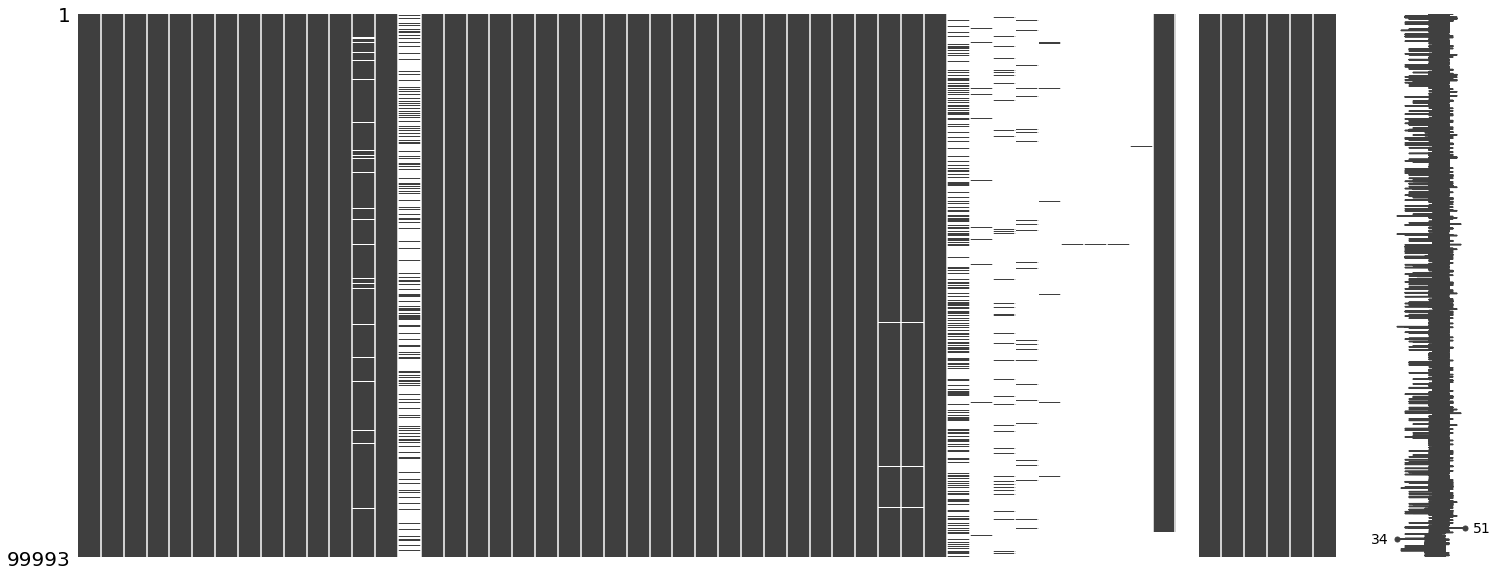

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99993 entries, 20183 to 0
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_record_id                99993 non-null  object        
 1   crash_date                     99993 non-null  datetime64[ns]
 2   posted_speed_limit             99993 non-null  int64         
 3   traffic_control_device         99993 non-null  object        
 4   device_condition               99993 non-null  object        
 5   weather_condition              99993 non-null  object        
 6   lighting_condition             99993 non-null  object        
 7   first_crash_type               99993 non-null  object        
 8   trafficway_type                99993 non-null  object        
 9   alignment                      99993 non-null  object        
 10  roadway_surface_cond           99993 non-null  object        
 11  road_defect    

In [16]:
#Visualising missing data
#Sorting values by report received date
collisions = collisions.sort_values(by='crash_date',ascending=True)

#plotting matrix of missing data
msno.matrix(collisions)
plt.show()

#info of sorted data
print(collisions.info())

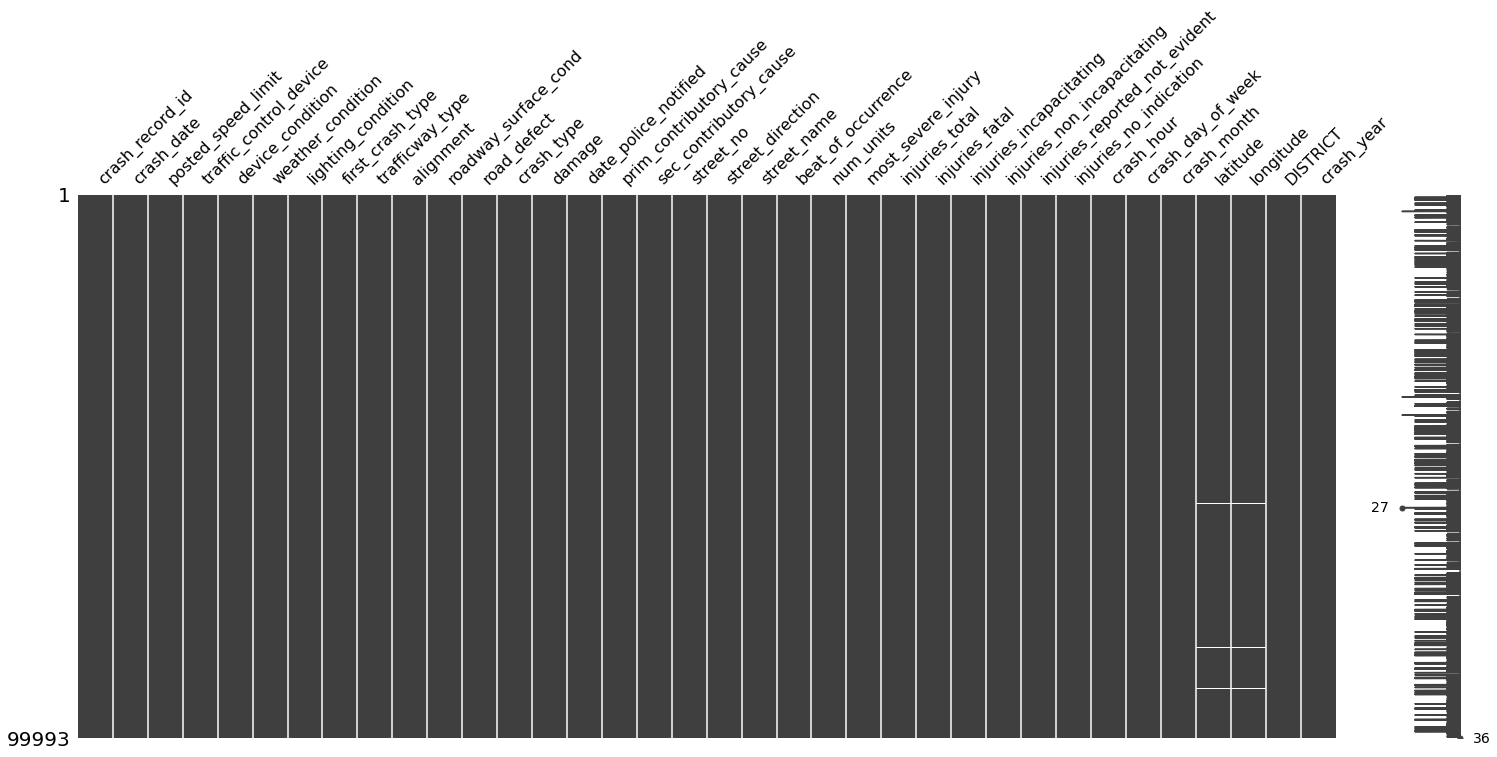

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99993 entries, 20183 to 0
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   crash_record_id                99993 non-null  object        
 1   crash_date                     99993 non-null  datetime64[ns]
 2   posted_speed_limit             99993 non-null  int64         
 3   traffic_control_device         99993 non-null  object        
 4   device_condition               99993 non-null  object        
 5   weather_condition              99993 non-null  object        
 6   lighting_condition             99993 non-null  object        
 7   first_crash_type               99993 non-null  object        
 8   trafficway_type                99993 non-null  object        
 9   alignment                      99993 non-null  object        
 10  roadway_surface_cond           99993 non-null  object        
 11  road_defect    

In [17]:
#dropping unnecessary columns
drop_cols = ['location', 'crash_date_est_i','report_type', 'intersection_related_i',
       'hit_and_run_i', 'photos_taken_i', 'crash_date_est_i', 'injuries_unknown',
       'private_property_i', 'statements_taken_i', 'dooring_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i','lane_cnt','the_geom','rd_no',
            'SECTOR','BEAT','BEAT_NUM']

collisions=collisions.drop(columns=drop_cols)

#plotting matrix of missing data
msno.matrix(collisions)
plt.show()

#info of sorted data
print(collisions.info())

In [18]:
#drop all rows with missing latitude/longitude data
collisions.dropna(subset=['longitude','latitude'],inplace=True)

#replacing all null values in injuries columns with 0
num_injury_cols = ['injuries_total','injuries_fatal','injuries_incapacitating',
                  'injuries_non_incapacitating','injuries_reported_not_evident',
                  'injuries_no_indication']
collisions[num_injury_cols] = collisions[num_injury_cols].fillna(0)

#replacing null values in most_severe_injury:
#['NO INDICATION OF INJURY' 'NONINCAPACITATING INJURY'
# 'REPORTED, NOT EVIDENT' nan 'FATAL' 'INCAPACITATING INJURY']




In [19]:
#creating column to define whether a car crash involved at least 1 casualty
collisions['casualty'] = (collisions['injuries_total'] > 0).astype(int)

#plotting collisions 

In [20]:
print(collisions.describe())

       posted_speed_limit     street_no  beat_of_occurrence     num_units  \
count        99101.000000  99101.000000        99101.000000  99101.000000   
mean            28.594727   3746.936842         1254.633142      2.036882   
std              5.591250   2825.627272          703.250766      0.469560   
min              0.000000      1.000000          111.000000      1.000000   
25%             30.000000   1400.000000          725.000000      2.000000   
50%             30.000000   3300.000000         1213.000000      2.000000   
75%             30.000000   5564.000000         1823.000000      2.000000   
max             65.000000  13787.000000         2535.000000     18.000000   

       injuries_total  injuries_fatal  injuries_incapacitating  \
count    99101.000000    99101.000000             99101.000000   
mean         0.206325        0.001443                 0.021846   
std          0.589620        0.041514                 0.174618   
min          0.000000        0.000000     

In [21]:
#Some incorrect lat/long data - need to remove these rows
collisions = collisions[collisions['longitude']<-80]
collisions = collisions[collisions['latitude']>40]

In [22]:
##########################################
#Step 5: Plot data
##########################################

<Figure size 1440x864 with 0 Axes>

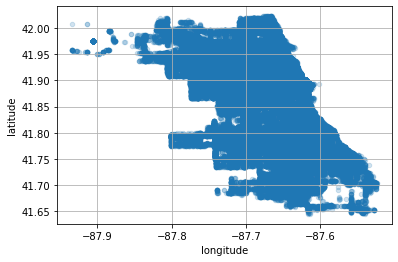

In [23]:
#setting range of plot to be the minimum/maximum values for lat/long

#plotting lat/long data showing locations of crashes
plt.figure(figsize=(20,12))
collisions.plot(kind='scatter',x='longitude',y='latitude',grid=True,legend='casualty',alpha=0.2)

plt.show()

In [24]:
#define function for getting scatter plot of 2 variables and printing correlation coefficient
def plot_correlation(df,var1,var2,group=None):
    sns.lmplot(x=var1,y=var2,hue=group,data=df,ci=0)
    plt.show()
    
    print(df[[var1,var2]].corr())
    
    return 

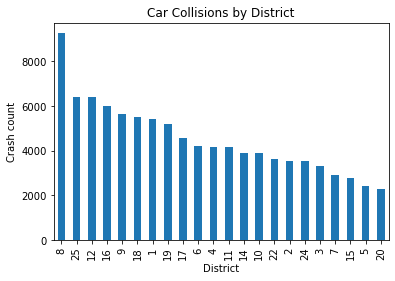

In [25]:
#plot graphs of fatalities by weather event, roadway condition
roadway_surf_count = collisions['DISTRICT'].value_counts()

roadway_surf_count.plot.bar()
plt.xlabel('District')
plt.ylabel('Crash count')
plt.title('Car Collisions by District')
plt.show()

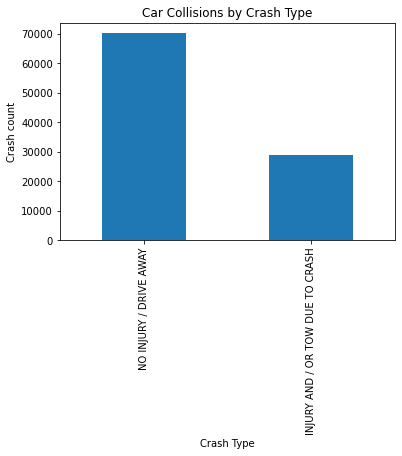

In [26]:
#plot graphs of crash type 
crash_type_count = collisions['crash_type'].value_counts()

crash_type_count.plot.bar()
plt.xlabel('Crash Type')
plt.ylabel('Crash count')
plt.title('Car Collisions by Crash Type')
plt.show()

In [27]:
#plot graphs of fatalities by weather event, roadway condition
injuries_total_count = collisions['injuries_incapacitating'].value_counts()

injuries_total_count

0.0    97253
1.0     1601
2.0      188
3.0       30
4.0       14
5.0        6
6.0        2
Name: injuries_incapacitating, dtype: int64

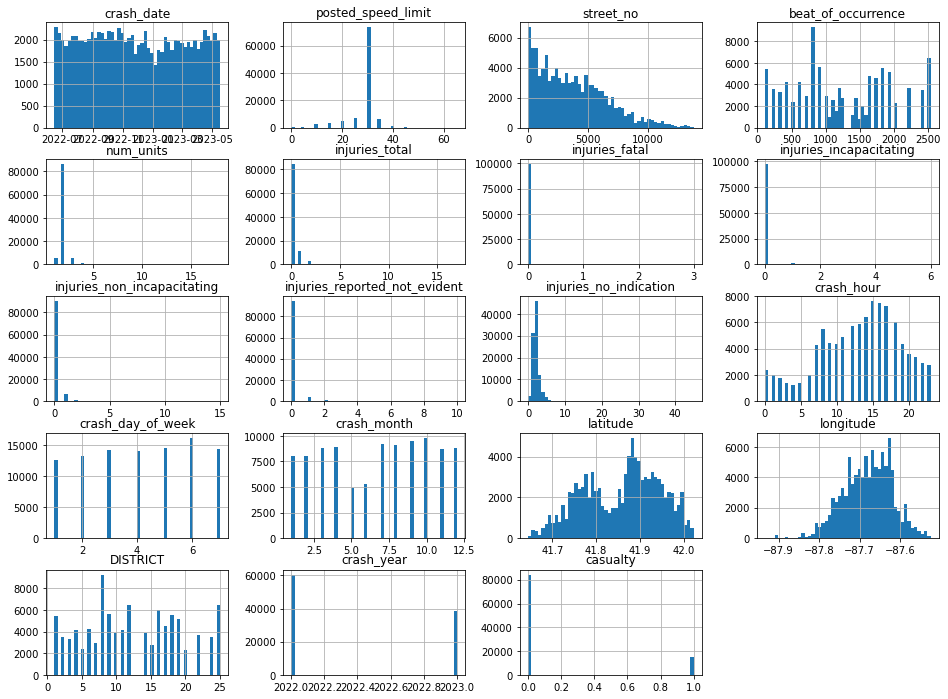

In [28]:
#plotting histograms of numerical values
collisions.hist(bins=50,figsize=(16,12))
plt.show()

In [29]:
##########################################
#Step 6: Machine Learning
##########################################

In [30]:
##Steps

#1. Exploratory Data Analysis - histograms, check for nulls, describe/info etc DONE
#2. Create test set (random or stratified, choose training set size) <--
#3. Data visualisation DONE
#4. Data preparation (combine some attributes, transform others, clean data, text vs. cat attributes, )
    ##NB - lots of categorical attributes in dataset, need to figure out how to deal with this
#5. Build a pipeline
#6. Select/train a model (look up classifier algorithms - decision tree/random forest etc)
#7. Evaluate model (look up good evaluation criteria for classification model)
#8. Fine tuning (GridsearchCV/RandomisedSearchCV)
#9. Ensemble methods
#10. Analyse best models and errors
#11. Evaluate on test set

In [31]:
#4. Data preparation (combine some attributes, transform others, clean data, text vs. cat attributes, )
    ##NB - lots of categorical attributes in dataset, need to figure out how to deal with this
#Note 1 - Latitude and longitude data should be transformed for ML analysis
#

collisions.columns

Index(['crash_record_id', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'crash_type',
       'damage', 'date_police_notified', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'crash_hour', 'crash_day_of_week',
       'crash_month', 'latitude', 'longitude', 'DISTRICT', 'crash_year',
       'casualty'],
      dtype='object')

In [32]:
ml_cols = ['posted_speed_limit','traffic_control_device', 'device_condition', 'weather_condition',
          'lighting_condition', 'first_crash_type', 'trafficway_type','alignment', 
           'roadway_surface_cond', 'road_defect', 'crash_type','damage','prim_contributory_cause',
          'sec_contributory_cause','street_direction','num_units', 'DISTRICT',
          'crash_hour','crash_day_of_week','latitude', 'longitude']
cat_cols = ['traffic_control_device', 'device_condition', 'weather_condition', 'DISTRICT',
           'lighting_condition', 'first_crash_type', 'trafficway_type','alignment',
           'roadway_surface_cond', 'road_defect', 'crash_type','damage','prim_contributory_cause',
           'sec_contributory_cause','street_direction','num_units']

collisions_ml = collisions[ml_cols].copy()

#encoding categorical values
label_encoder = LabelEncoder()
for col in collisions_ml[cat_cols].columns:
    collisions_ml[col] = label_encoder.fit_transform(collisions_ml[col])


In [33]:
#scaling latitude and longitude data
scaler = StandardScaler()

# Logarithmic transformation on longitude
collisions_ml['neg_log_longitude'] = scaler.fit_transform(np.log1p(-collisions_ml['longitude']).values.reshape(-1,1))

# Normalisation on latitude
collisions_ml['norm_latitude'] = scaler.fit_transform(collisions['latitude'].values.reshape(-1, 1))

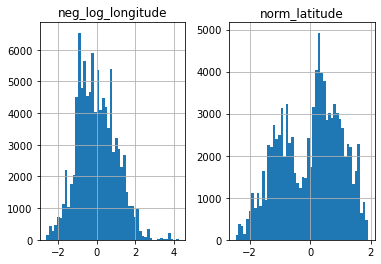

In [34]:
collisions_ml[['neg_log_longitude','norm_latitude']].hist(bins=50)
plt.show()

In [35]:
#transforming crash_hour - 
#data is cyclic, can be encoded using trig transforms

#trig transformation - sin(crash_hr)
collisions_ml['cos_hr'] = np.cos(2*np.pi*collisions_ml['crash_hour']/24)


In [36]:
#drop previous latitude/longitude columns
lat_long_drop_cols = ['longitude','latitude']
collisions_ml.drop(lat_long_drop_cols,axis=1,inplace=True)

#drop crash_hour column
collisions_ml.drop('crash_hour',axis=1,inplace=True)

<AxesSubplot:>

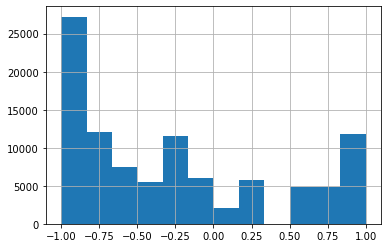

In [37]:
collisions_ml['cos_hr'].hist(bins=12)

In [38]:
#2. Create test set (random or stratified, choose training set size) <--
#setting X and y values

X = collisions_ml.drop('crash_type', axis=1)
y = collisions_ml['crash_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
#validation set 
#can use to check how it performs in an entirely separate model
#can use CV instead

In [40]:
print(collisions_ml.head())

       posted_speed_limit  traffic_control_device  device_condition  \
20183                  30                       3                 3   
80464                  20                       3                 3   
31565                  30                       3                 3   
15530                  35                      14                 1   
98140                  30                       3                 3   

       weather_condition  lighting_condition  first_crash_type  \
20183                  2                   3                 7   
80464                  2                   3                 5   
31565                 11                   5                 7   
15530                  2                   3                17   
98140                  2                   3                17   

       trafficway_type  alignment  roadway_surface_cond  road_defect  ...  \
20183               10          3                     0            1  ...   
80464                8

In [41]:
#6. Select/train a model (look up classifier algorithms - decision tree/random forest etc)


In [50]:
#Classifier 1 - Random Forest
RFClassifier = RandomForestClassifier(n_estimators=300,min_samples_split=10)

RFClassifier.fit(X_train,y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=300)

In [51]:
#Predictions
#make predictions on the training set
y_train_pred = RFclassifier.predict(X_train)

# Make predictions on the test data
y_test_pred = RFclassifier.predict(X_test)

In [61]:
#7. Evaluate model (look up good evaluation criteria for classification model)
# Calculate the accuracy of the model

#calculating accuracy of model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)

#calculating accuracy of model on test data
test_accuracy = accuracy_score(y_test, y_test_pred)

#computing f1 score,precision,recall
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test,y_test_pred)
recall = recall_score(y_test,y_test_pred)

#comparing performances
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

#print precision score
print("Precision Score:", precision)

#print recall score
print("Recall Score:", recall)

#print f1 score
print("F1 Score:", f1)


Training Accuracy: 0.9999747713654998
Test Accuracy: 0.7865684444220192
Precision Score: 0.816267200723561
Recall Score: 0.9011482775836246
F1 Score: 0.8566101694915255


In [68]:
#Classifier 2 - K Nearest Neighbours
#instantiate KNN Classifier
KNNClassifier = KNeighborsClassifier(n_neighbors=10)

KNNClassifier.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=10)

In [69]:
#Predictions
#make predictions on the training set
y_train_pred = KNNClassifier.predict(X_train)

# Make predictions on the test data
y_test_pred = KNNClassifier.predict(X_test)

In [70]:
#7. Evaluate model
# Calculate the accuracy of the model

#calculating accuracy of model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)

#calculating accuracy of model on test data
test_accuracy = accuracy_score(y_test, y_test_pred)

#computing f1 score,precision,recall
f1 = f1_score(y_test, y_test_pred)
precision = precision_score(y_test,y_test_pred)
recall = recall_score(y_test,y_test_pred)

#comparing performances
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

#print precision score
print("Precision Score:", precision)

#print recall score
print("Recall Score:", recall)

#print f1 score
print("F1 Score:", f1)


Training Accuracy: 0.7757174392935983
Test Accuracy: 0.7225894343811494
Precision Score: 0.7686440143730694
Recall Score: 0.8696241352257328
F1 Score: 0.8160219515459777


In [65]:
#cross val to determine optimal n_neighbors

# Define the range of n_neighbors values to explore
n_range = range(1, 21)

# Create an empty list to store the mean cross-validation scores
cv_scores = []

# Perform cross-validation for each n_neighbors value
for n in n_range:
    # Create a KNN classifier with n_neighbors value
    knn = KNeighborsClassifier(n_neighbors=n)
    
    # Perform cross-validation using 5-fold CV
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    
    # Compute the mean cross-validation score
    mean_score = np.mean(scores)
    
    # Append the mean score to the cv_scores list
    cv_scores.append(mean_score)

# Find the optimal number of neighbors with the highest score
opt_n = n_range[np.argmax(cv_scores)]

print("Optimal number of neighbors:", opt_n)

Optimal number of neighbors: 20


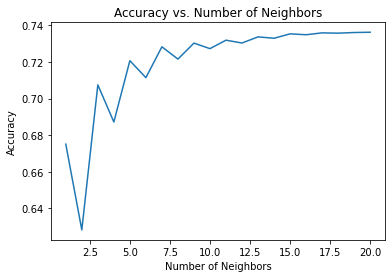

In [67]:
# Plot the accuracy vs. number of neighbors
plt.plot(n_range, cv_scores)
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.show()

In [72]:
#feature engineering
# Retrieve the feature importances from the trained classifier
importances = RFClassifier.feature_importances_

# Create a DataFrame to display the feature importances
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
print(feature_importances_df)

                    Feature  Importance
5          first_crash_type    0.155163
18            norm_latitude    0.099653
17        neg_log_longitude    0.098627
11  prim_contributory_cause    0.079781
14                num_units    0.065950
10                   damage    0.065239
19                   cos_hr    0.059468
6           trafficway_type    0.050415
15                 DISTRICT    0.048421
16        crash_day_of_week    0.041195
12   sec_contributory_cause    0.040658
4        lighting_condition    0.036774
0        posted_speed_limit    0.032169
1    traffic_control_device    0.024505
3         weather_condition    0.023152
2          device_condition    0.021866
13         street_direction    0.020077
8      roadway_surface_cond    0.016754
9               road_defect    0.013940
7                 alignment    0.006193


In [ ]:
#8. Fine tuning (GridsearchCV/RandomisedSearchCV)
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create an instance of Randomized Search Cross-Validation
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_grid, cv=5)

# Perform the randomized search on the training data
random_search.fit(X_train, y_train)

# Retrieve the best model and its performance
best_classifier = random_search.best_estimator_
best_accuracy = random_search.best_score_

print("Best Accuracy:", best_accuracy)
print("Best Model:", best_classifier)

In [ ]:
#10. Analyse best models and errors

In [ ]:
#11. Evaluate on test set